In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import time

In [ ]:
#mounting drive to access dataset
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_path = '/content/drive/MyDrive/Faces'

#loading data
images = []
labels = []
print(f"Loading images from: {dataset_path}")

for i in range(1, 41):
    subject_path = os.path.join(dataset_path, f's{i}')
    for img_name in os.listdir(subject_path):
        if img_name.endswith('.pgm'):
            img_path = os.path.join(subject_path, img_name)
            img = Image.open(img_path).convert('L')
            images.append(np.array(img).flatten())
            labels.append(i)

X = np.array(images, dtype=np.float64) #shape=(N_images, D_pixels)=(400,10304)
#Row i of X = pixel intensity values of the i-th image.
#Column j of X = the j-th pixel across all images.
#Each entry is a grayscale intensity (0–255).

y = np.array(labels) #shape=(N_images,)=(400,)
#stores the person ID (class label) for each image.
#Y[i] tells you which person the image in X[i] belongs to.



Loading images from: /content/drive/MyDrive/Faces


In [ ]:
print("X.shape:", X.shape)
print("min/max pixel:", X.min(), X.max())


X.shape: (400, 10304)
min/max pixel: 0.0 251.0


In [ ]:
#split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

#preprocessing: mean-centering

#calculating the mean face (average of all training images)
mean_face = np.mean(X_train, axis=0)

#subtract the mean face from the training and testing sets to center data
X_train_centered = X_train - mean_face
X_test_centered = X_test - mean_face
#because pca requires zero-mean data to compute meaningful covariance

print(f"Total images loaded: {len(X)}")
print(f"Shape of centered training data: {X_train_centered.shape}")
print(f"Shape of centered testing data: {X_test_centered.shape}")

Total images loaded: 400
Shape of centered training data: (280, 10304)
Shape of centered testing data: (120, 10304)


In [ ]:
# eigenface calculation
# computing (X @ X.T) = (280x280)
L = X_train_centered @ X_train_centered.T
print(f"Shape of the smaller matrix L: {L.shape}")

# Find eigenvalues and eigenvectors of the smaller matrix L
eigenvalues, eigenvectors_small = np.linalg.eigh(L)

# sorting eigenvectors by descending eigenvalues

#creating a map that tells you how to sort eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]

sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors_small = eigenvectors_small[:, sorted_indices]

# Reconstruct the actual Eigenfaces for the original space
# The actual eigenvectors (Eigenfaces) are derived from the smaller ones.
# Eigenface u_i = X_train_centered.T @ v_i (where v_i is an eigenvector of L)
eigenfaces = X_train_centered.T @ sorted_eigenvectors_small

# Normalize the Eigenfaces
# To be true eigenvectors, they must have unit length.
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

# The normalized Eigenfaces are our principal components
principal_components = eigenfaces

print(f"Shape of our Principal Components (Eigenfaces): {principal_components.shape}")

Shape of the smaller matrix L: (280, 280)
Shape of our Principal Components (Eigenfaces): (10304, 280)


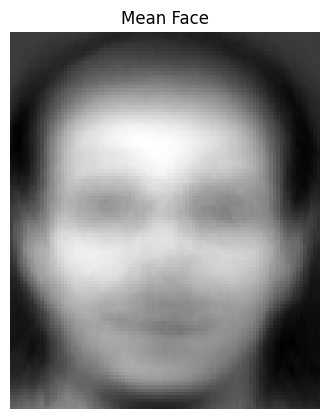

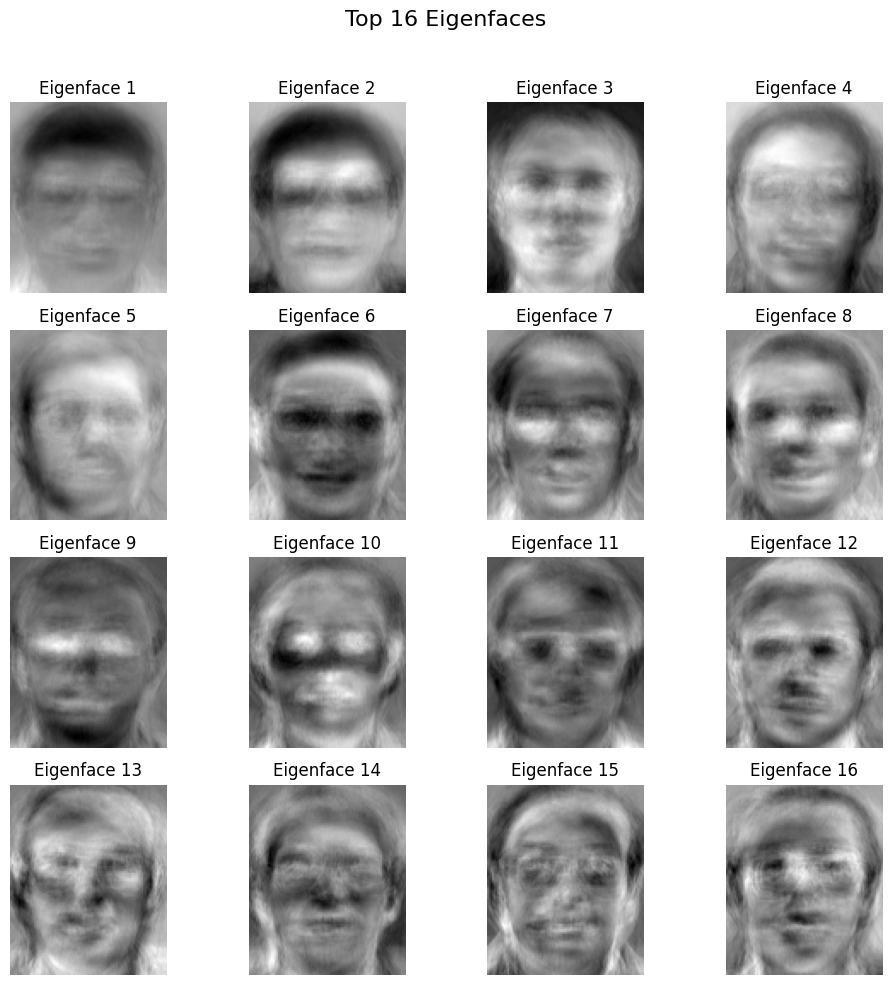

In [ ]:
# Display the mean face
plt.figure(figsize=(4, 5))
plt.imshow(mean_face.reshape(112, 92), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

# Visualize the first few Eigenfaces
num_eigenfaces_to_show = 16
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    eigenface = principal_components[:, i].reshape(112, 92)
    ax.imshow(eigenface, cmap='gray')
    ax.set_title(f"Eigenface {i+1}")
    ax.axis('off')

plt.suptitle("Top 16 Eigenfaces", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

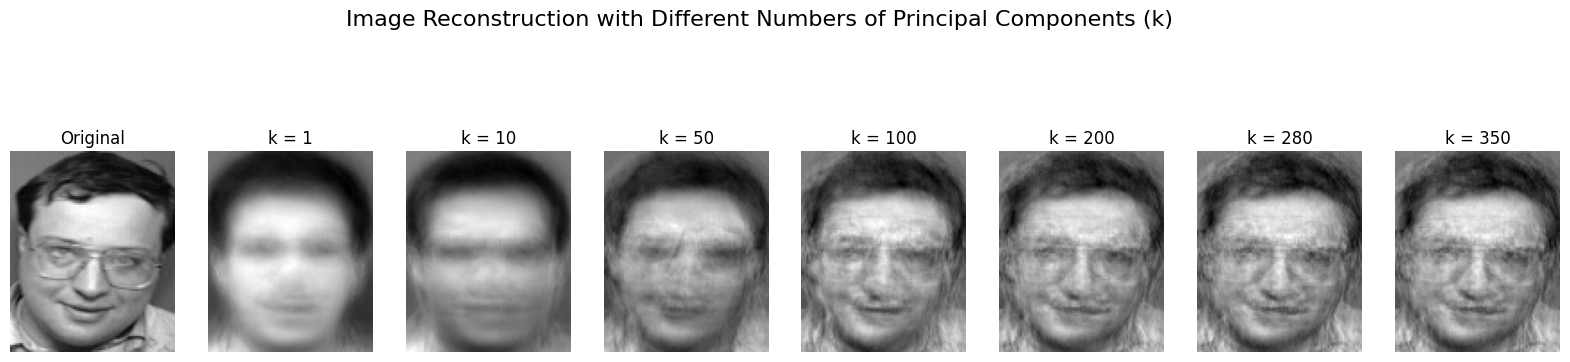

In [ ]:
# Choose a sample image from the test set to reconstruct
sample_idx = 0
original_image = X_test[sample_idx]
original_image_centered = X_test_centered[sample_idx]

# k = number of principal comp or eigenfaces
k_values = [1, 10, 50, 100, 200, 280, 350]

fig, axes = plt.subplots(1, len(k_values) + 1, figsize=(20, 5))

# Displaying original image
axes[0].imshow(original_image.reshape(112, 92), cmap='gray')
axes[0].set_title("Original")
axes[0].axis('off')

# Reconstruct and display for different k
for i, k in enumerate(k_values):
  #from full set of pc, chooses only first k columns
    W_k = principal_components[:, :k]

    # Project the sample image into the k-dimensional PCA space(for orginal iamge, what is right amount of eigenfaces needed to describe it)
    projected_image = original_image_centered @ W_k

    # Reconstruct the image back to the original space
    reconstructed_image_centered = projected_image @ W_k.T
    # Add the mean face back to see the actual image
    reconstructed_image = reconstructed_image_centered + mean_face

    axes[i+1].imshow(reconstructed_image.reshape(112, 92), cmap='gray')
    axes[i+1].set_title(f"k = {k}")
    axes[i+1].axis('off')

plt.suptitle("Image Reconstruction with Different Numbers of Principal Components (k)", fontsize=16)
plt.show()

In [ ]:
# Function to perform nearest neighbor classification
def nearest_neighbor_classifier(X_train_pca, y_train, X_test_pca):
    predictions = []
    for test_vec in X_test_pca:
      # calculates the Euclidean distance (the straight-line distance) from the new test_vec to every single point in the training set (X_train_pca) simultaneously.
        distances = np.linalg.norm(X_train_pca - test_vec, axis=1)

        # find the index (the position in the list) of the minimum value in the distances
        # This index tells us exactly which training image is the closest match "nearest neighbor."
        nearest_neighbor_idx = np.argmin(distances)
        predictions.append(y_train[nearest_neighbor_idx])
    return np.array(predictions)

#to find optimal k
k_range = list(range(1, 151, 5))
accuracies = []
print("Calculating recognition accuracy for different values of k...")

start_time = time.time()
for k in k_range:
    # Select the top 'k' components
    W_k = principal_components[:, :k]
    # Project training and testing data into k-dimentional PCA space
    X_train_pca = X_train_centered @ W_k
    X_test_pca = X_test_centered @ W_k
    # run classifier and get predictions
    y_pred = nearest_neighbor_classifier(X_train_pca, y_train, X_test_pca)
    # Calculate accuracy
    accuracy = np.mean(y_pred == y_test)#creates an array of True (correct prediction) and False (incorrect) values.
    #taking the mean gives you the percentage of correct predictions.
    accuracies.append(accuracy)


Calculating recognition accuracy for different values of k...


Visualizing predictions for the best k = 36


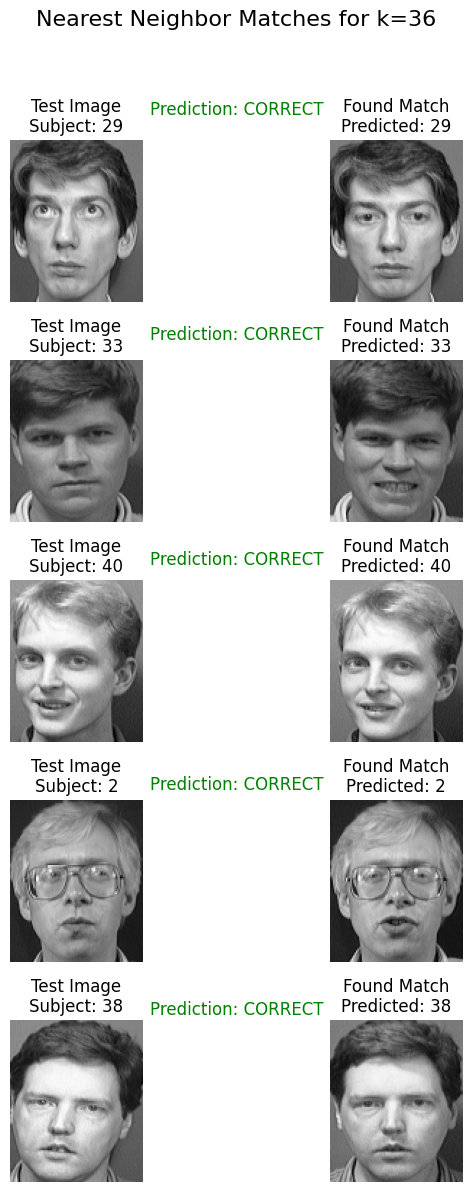

In [ ]:
#Pick the best (highest) K from our previous accuracy calculation
best_k = k_range[np.argmax(accuracies)]
print(f"Visualizing predictions for the best k = {best_k}")
#best_k = the best-performing number of components.

#Preparing data for final classification by transforming the images into their optimal, low-dim representation
#Project the data using the best k and creating  optimal set of Eigenfaces (W_best)
W_best = principal_components[:, :best_k]
X_train_pca = X_train_centered @ W_best
X_test_pca = X_test_centered @ W_best

#Select a few random samples from the test set to visualize
num_samples_to_show = 5
# np.random.choice ensures we get different images each time you run it
sample_indices = np.random.choice(len(X_test), num_samples_to_show, replace=False)

# Find nearest neighbor and display
fig, axes = plt.subplots(num_samples_to_show, 2, figsize=(8, 2.5 * num_samples_to_show))
fig.suptitle(f'Nearest Neighbor Matches for k={best_k}', fontsize=16)

for i, idx in enumerate(sample_indices):
    # Get the PCA representation of our single test image
    test_vec = X_test_pca[idx]

    # Calculate its distance to ALL training images in PCA space
    distances = np.linalg.norm(X_train_pca - test_vec, axis=1)

    # Find the index of the closest training image
    nearest_neighbor_idx = np.argmin(distances)

    # Get the original images
    original_test_image = X_test[idx].reshape(112, 92)
    found_neighbor_image = X_train[nearest_neighbor_idx].reshape(112, 92)

    # Get the true and predicted labels
    true_label = y_test[idx]
    predicted_label = y_train[nearest_neighbor_idx]

    # Plotting
    # Plot Test Image
    axes[i, 0].imshow(original_test_image, cmap='gray')
    axes[i, 0].set_title(f'Test Image\nSubject: {true_label}')
    axes[i, 0].axis('off')

    # Plot Found Neighbor
    axes[i, 1].imshow(found_neighbor_image, cmap='gray')
    axes[i, 1].set_title(f'Found Match\nPredicted: {predicted_label}')
    axes[i, 1].axis('off')

    # Add a text label to show if the prediction was correct
    if predicted_label == true_label:
        fig.text(0.5, 0.9 - i*(0.9/num_samples_to_show), 'Prediction: CORRECT', ha='center', va='center', color='green', fontsize=12)
    else:
        fig.text(0.5, 0.9 - i*(0.9/num_samples_to_show), 'Prediction: INCORRECT', ha='center', va='center', color='red', fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

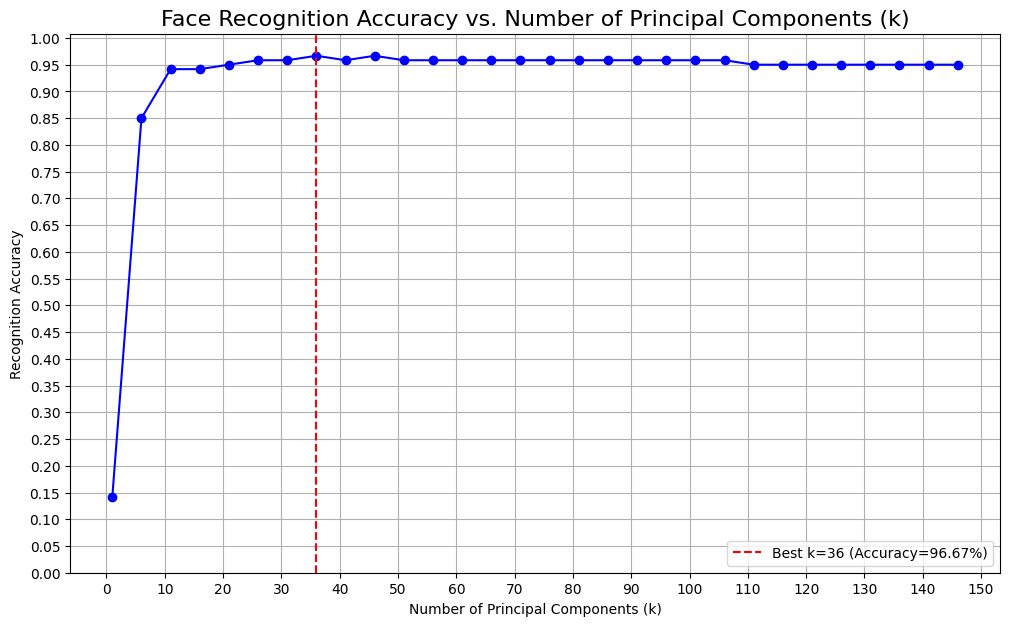

Maximum accuracy achieved: 96.67%
Achieved with k = 36 principal components.


In [ ]:
# --- Plot recognition accuracy vs. number of principal components ---
plt.figure(figsize=(12, 7))
plt.plot(k_range, accuracies, marker='o', linestyle='-', color='b')
plt.title('Face Recognition Accuracy vs. Number of Principal Components (k)', fontsize=16)
plt.xlabel('Number of Principal Components (k)')
plt.ylabel('Recognition Accuracy')
plt.grid(True)
plt.xticks(np.arange(0, 151, 10))
plt.yticks(np.arange(0.0, 1.05, 0.05))
best_k = k_range[np.argmax(accuracies)]
best_acc = max(accuracies)
plt.axvline(x=best_k, color='r', linestyle='--', label=f'Best k={best_k} (Accuracy={best_acc:.2%})')
plt.legend()
plt.show()

print(f"Maximum accuracy achieved: {best_acc:.2%}")
print(f"Achieved with k = {best_k} principal components.")

Calculating reconstruction error for different K values...

--- Test Set Reconstruction MSE ---
K=  5   test MSE=834.4520
K= 10   test MSE=665.8868
K= 20   test MSE=536.0085
K= 30   test MSE=473.8001
K= 40   test MSE=432.6511
K= 50   test MSE=406.5048
K= 60   test MSE=384.0754
K= 80   test MSE=355.7603
K=100   test MSE=336.9553
K=120   test MSE=323.5106
K=150   test MSE=308.4587
K=200   test MSE=290.6044
K=250   test MSE=277.2852
K=280   test MSE=272.3847


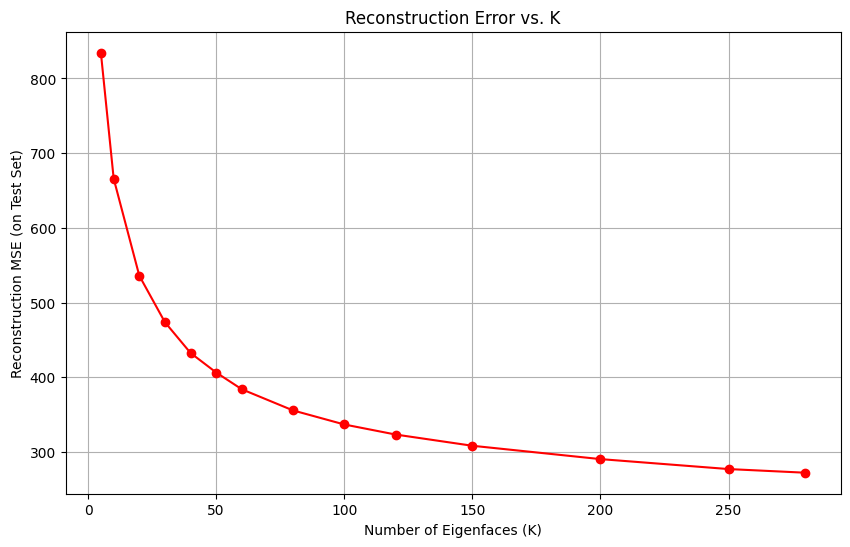

In [ ]:
# Reconstruction Error vs. Number of Components (K)

# Define the function to calculate Mean Squared Reconstruction Error
def recon_error(U_K, X, mu):
    # Center the original data
    Xc = X - mu
    # Project and reconstruct the data
    X_reconstructed_centered = (Xc @ U_K) @ U_K.T
    # Add the mean back
    X_reconstructed = X_reconstructed_centered + mu
    # Calculate the mean squared error between original and reconstructed
    mse = np.mean((X - X_reconstructed)**2)
    return mse

# A list of K values to test
Ks_re = [5, 10, 20, 30, 40, 50, 60, 80, 100, 120, 150, 200, 250, 280]
errs = []

print("Calculating reconstruction error for different K values...")
for K in Ks_re:
    # Get the top K eigenfaces
    U_K = principal_components[:, :K]
    # Calculate error on the test set and append to list
    errs.append(recon_error(U_K, X_test, mean_face))

# Print the results
print("\n--- Test Set Reconstruction MSE ---")
for k, e in zip(Ks_re, errs):
    print(f"K={k:>3}   test MSE={e:.4f}")

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(Ks_re, errs, marker="o", color='red')
plt.xlabel("Number of Eigenfaces (K)")
plt.ylabel("Reconstruction MSE (on Test Set)")
plt.title("Reconstruction Error vs. K")
plt.grid(True)
plt.show()




--- Cumulative Explained Variance ---
Number of components needed to explain 90% of variance: 91
Number of components needed to explain 95% of variance: 147
Number of components needed to explain 99% of variance: 235


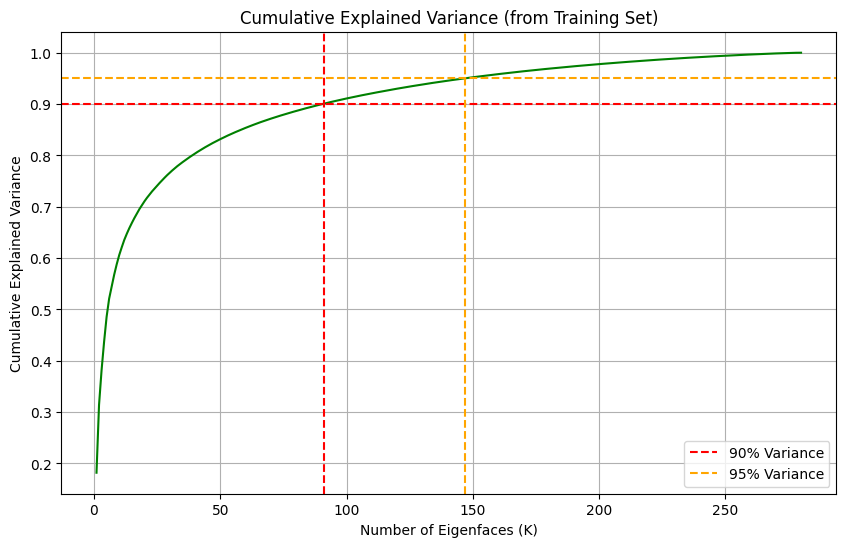

In [ ]:
# Cumulative Explained Variance vs. Number of Components (K)

# The `sorted_eigenvalues` from Cell 4 correspond to the variance of each component
total_variance = np.sum(sorted_eigenvalues)
explained_variance_ratio = sorted_eigenvalues / total_variance
cev = np.cumsum(explained_variance_ratio)

# Find the number of components needed for different variance thresholds
k_90 = np.argmax(cev >= 0.90) + 1
k_95 = np.argmax(cev >= 0.95) + 1
k_99 = np.argmax(cev >= 0.99) + 1

print("\n--- Cumulative Explained Variance ---")
print(f"Number of components needed to explain 90% of variance: {k_90}")
print(f"Number of components needed to explain 95% of variance: {k_95}")
print(f"Number of components needed to explain 99% of variance: {k_99}")

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cev) + 1), cev, color='green')
plt.xlabel("Number of Eigenfaces (K)")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance (from Training Set)")
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance')
plt.axvline(x=k_90, color='r', linestyle='--')
plt.axhline(y=0.95, color='orange', linestyle='--', label='95% Variance')
plt.axvline(x=k_95, color='orange', linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

Projected data for t-SNE has shape: (400, 50)
Running t-SNE... (this may take a moment)


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE finished.


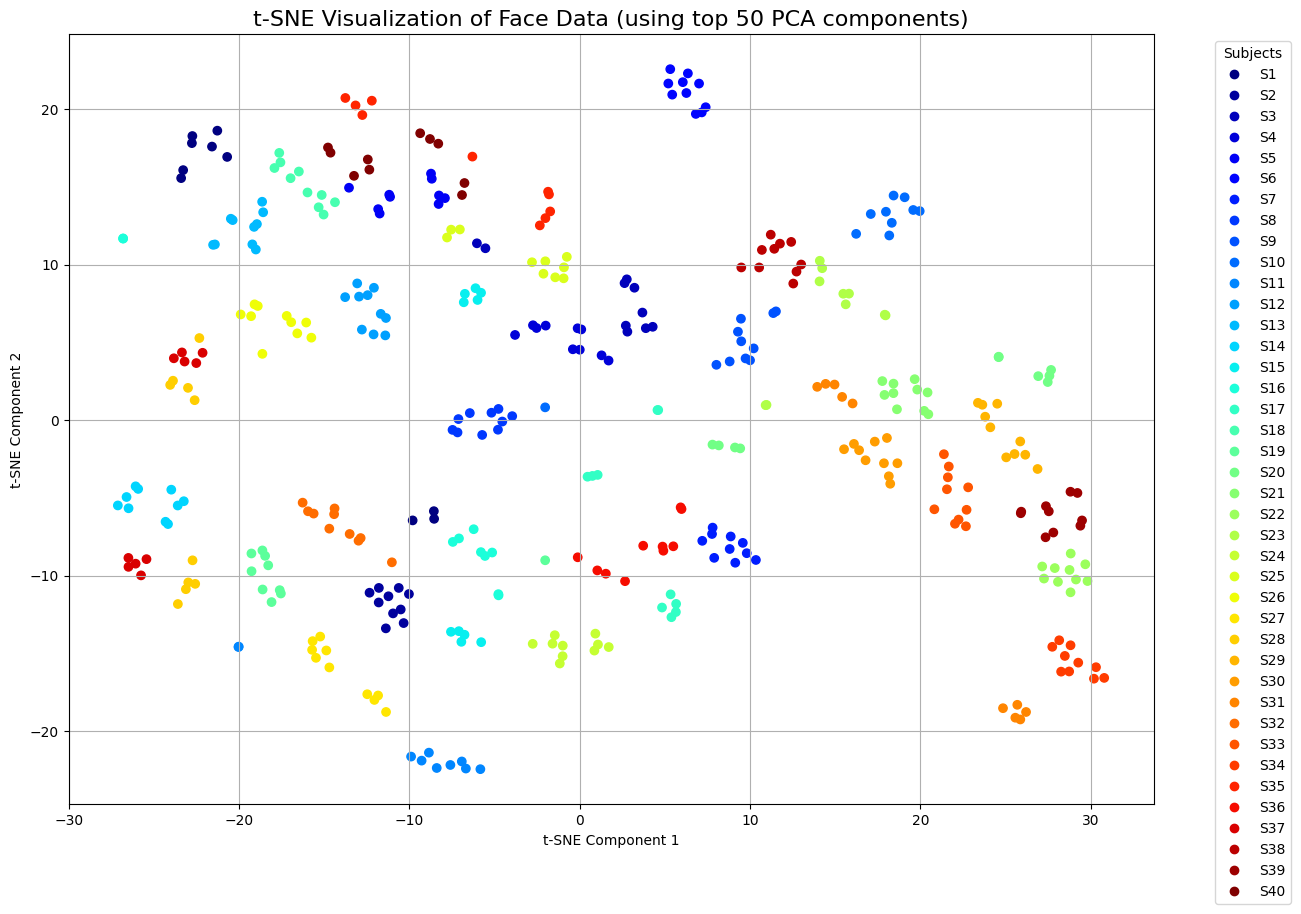

In [ ]:
# --- Use PCA feature representations as input to t-SNE ---
k_for_tsne = 50
W_tsne = principal_components[:, :k_for_tsne]

# Project the full dataset into this PCA space
X_centered = X - mean_face
X_pca = X_centered @ W_tsne
print(f"Projected data for t-SNE has shape: {X_pca.shape}")

# --- Reduce to 2D for visualization using t-SNE ---
print("Running t-SNE... (this may take a moment)")
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_pca)
print("t-SNE finished.")

# --- Plot the resulting clusters ---
plt.figure(figsize=(14, 10))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap=plt.get_cmap('jet', 40))
plt.title(f't-SNE Visualization of Face Data (using top {k_for_tsne} PCA components)', fontsize=16)
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements(num=40)[0], labels=[f'S{i}' for i in range(1, 41)], bbox_to_anchor=(1.05, 1), loc='upper left', title="Subjects")
plt.grid(True)
plt.show()